# Autoencoder

In [131]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [41]:
train_dataset = MNIST(root='../datasets/', transform=transforms.ToTensor(), train=True, download=True)
val_dataset = MNIST(root='../datasets/', transform=transforms.ToTensor(), train=False, download=False)

In [42]:
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

In [169]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=1600, out_features=10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=10, out_features=1600),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (64, 5, 5)),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [170]:
# test input and output shapes
autoencoder = Autoencoder()
batch, _ = next(iter(train_dataloader))
print(batch.shape)
test = autoencoder(batch)
print(test.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


In [171]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, _) in enumerate(dataloader):
            features = features.to(DEVICE)
            output = model(features)
            loss = criterion(output, features)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss
    return loss_sum/num_samples

In [172]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler=None):
    history = {"train_loss": [], "val_loss": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        for batch_idx, (features, _) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            output = model(features)
            
            # Calculate Loss
            loss = criterion(output, features)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss = track_performance(train_dataloader, model, criterion)
        val_loss = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}')
        
        if scheduler:
          scheduler.step(val_loss)
    return history          


In [174]:
LR = 0.0001
NUM_EPOCHS = 20
DEVICE = torch.device('cuda')

In [175]:
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='mean')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='min',
                                                       patience=2,
                                                       verbose=True)

In [176]:
history = train(NUM_EPOCHS, train_dataloader, val_dataloader, autoencoder, criterion, optimizer, scheduler)

Epoch:  1/20 | Train Loss: 0.00061 | Val Loss: 0.00061
Epoch:  2/20 | Train Loss: 0.00041 | Val Loss: 0.00040
Epoch:  3/20 | Train Loss: 0.00036 | Val Loss: 0.00035
Epoch:  4/20 | Train Loss: 0.00034 | Val Loss: 0.00034
Epoch:  5/20 | Train Loss: 0.00032 | Val Loss: 0.00032
Epoch:  6/20 | Train Loss: 0.00031 | Val Loss: 0.00031
Epoch:  7/20 | Train Loss: 0.00030 | Val Loss: 0.00030
Epoch:  8/20 | Train Loss: 0.00029 | Val Loss: 0.00029
Epoch:  9/20 | Train Loss: 0.00029 | Val Loss: 0.00028
Epoch: 10/20 | Train Loss: 0.00028 | Val Loss: 0.00028
Epoch: 11/20 | Train Loss: 0.00028 | Val Loss: 0.00027
Epoch: 12/20 | Train Loss: 0.00027 | Val Loss: 0.00027
Epoch: 13/20 | Train Loss: 0.00027 | Val Loss: 0.00027
Epoch: 14/20 | Train Loss: 0.00026 | Val Loss: 0.00026
Epoch: 15/20 | Train Loss: 0.00026 | Val Loss: 0.00026
Epoch: 16/20 | Train Loss: 0.00026 | Val Loss: 0.00026
Epoch: 17/20 | Train Loss: 0.00025 | Val Loss: 0.00025
Epoch: 18/20 | Train Loss: 0.00025 | Val Loss: 0.00025
Epoch: 19/

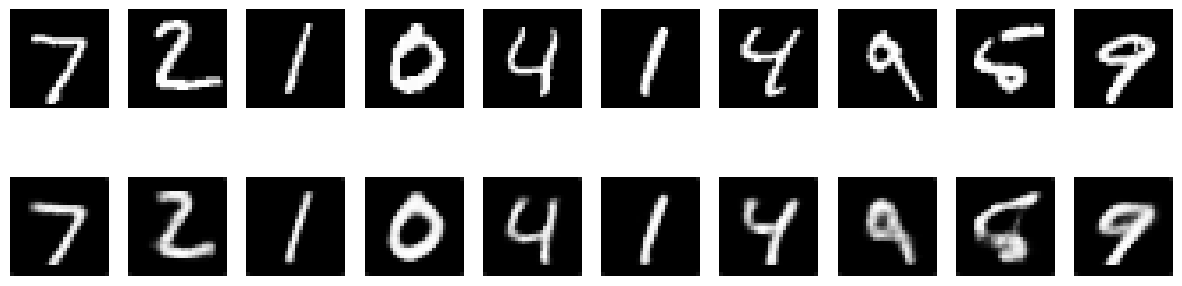

In [177]:
# draw original and reconstructed images
batch, _ = next(iter(val_dataloader))
batch = batch[:10, ...]
fig = plt.figure(figsize=(15, 4))

with torch.inference_mode():
    for i, img in enumerate(batch):
        fig.add_subplot(2, 10, i+1)
        orig_img = img.numpy()[0]
        plt.imshow(orig_img, cmap="gray")
        plt.axis('off')
        
        fig.add_subplot(2, 10, i+1+10)
        img = img.unsqueeze(0).to(DEVICE)
        rec_img = autoencoder(img).squeeze().cpu().numpy()
        plt.imshow(rec_img, cmap="gray")
        plt.axis('off')

    plt.show()

In [208]:
# create average for the number 0
latent_vars = []
with torch.inference_mode():
    for i, (features, labels) in enumerate(train_dataloader):
        mask = labels==0
        if mask.sum() > 0:
            features = features[mask]
            latent = autoencoder.encoder(features.to(DEVICE))
            latent_vars.append(latent)
        
    latent_vars = torch.cat(latent_vars, dim=0)
    avg_latent_var = latent_vars.mean(dim=0, keepdim=True)  
    img = autoencoder.decoder(avg_latent_var)

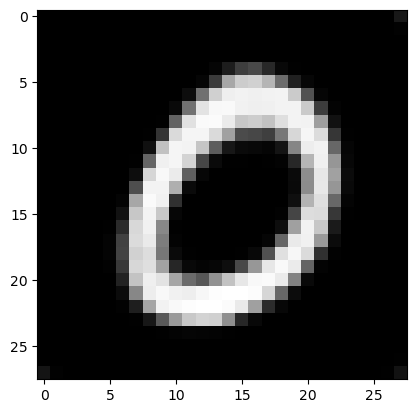

In [209]:
# draw a 0 that corresponds to an average latent space
img = img.squeeze().cpu().numpy()
plt.imshow(img, cmap="gray")